In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from numpy import exp
from scipy import ndimage
from func import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

In [2]:
def scale_factor_spectrum(z,data,error,wave):
    k = 1+z
    select1 = (wave>6750*k) & (wave<6800*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact

In [3]:
def aperture_spec_fit(z,int_spectrum,int_err,mini_wave,p_init,broad2=False,MC_loops=100):
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(mini_wave,int_spectrum,int_err),maxfev = 10000000)       
    fitted=(full_gauss(popt_full_fit,mini_wave,int_spectrum,int_err))*(int_err)+int_spectrum 
    residual = int_spectrum - fitted
    v_out = popt_full_fit[2] - popt_full_fit[6]
    (amp_Hb,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2,m,c) = popt_full_fit
    sigma_eff_Hb1 = line_width_recons(vel_sigma_Hb1,rest_line=4861.33,inst_res_fwhm=0)
    sigma_eff_Hb2 = line_width_recons(vel_sigma_Hb2,rest_line=4861.33,inst_res_fwhm=0) 
    flux = flux_blr(amp_Hb1,amp_Hb2,sigma_eff_Hb1,sigma_eff_Hb2,broad2)
    Hb_lum = Hb_blr_lum(z,flux)          
    cor_popt = np.array([amp_OIII5007,amp_OIII5007_br,vel_OIII,vel_sigma_OIII,vel_OIII_br,vel_sigma_OIII_br])
    (wav_min,wav_max) = wavlim(vel_OIII,vel_OIII_br)
    w80 = line_shape_par(z,wav_min,wav_max,cor_popt)
    parameters = [amp_Hb,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2,m,c,v_out,w80,Hb_lum]

    spec_parameters_MC = np.zeros((len(parameters),MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(int_spectrum,int_err)   
        popt_MC,pcov_MC = leastsq(full_gauss,x0=p_init,args=(mini_wave,iteration_data,int_err),maxfev = 10000000)
        v_out_MC = popt_MC[2] - popt_MC[6]
        (amp_Hb_MC,amp_OIII5007_MC,vel_OIII_MC,vel_sigma_OIII_MC,amp_Hb_br_MC,amp_OIII5007_br_MC,vel_OIII_br_MC,vel_sigma_OIII_br_MC,amp_Hb1_MC,amp_Fe5018_1_MC,vel_Hb1_MC,vel_sigma_Hb1_MC,amp_Hb2_MC,amp_Fe5018_2_MC,vel_Hb2_MC,vel_sigma_Hb2_MC,m_MC,c_MC) = popt_MC
        sigma_eff_Hb1_MC = line_width_recons(vel_sigma_Hb1_MC,rest_line=4861.33,inst_res_fwhm=0)
        sigma_eff_Hb2_MC = line_width_recons(vel_sigma_Hb2_MC,rest_line=4861.33,inst_res_fwhm=0) 
        flux_MC = flux_blr(amp_Hb1_MC,amp_Hb2_MC,sigma_eff_Hb1_MC,sigma_eff_Hb2_MC,broad2)
        Hb_lum_MC = Hb_blr_lum(z,flux_MC)  
        cor_popt_MC = np.array([amp_OIII5007_MC,amp_OIII5007_br_MC,vel_OIII_MC,vel_sigma_OIII_MC,vel_OIII_br_MC,vel_sigma_OIII_br_MC])
        (wav_min,wav_max) = wavlim(vel_OIII_MC,vel_OIII_br_MC)
        w80_MC = line_shape_par(z,wav_min,wav_max,cor_popt_MC)
        par_MC = [amp_Hb_MC,amp_OIII5007_MC,vel_OIII_MC,vel_sigma_OIII_MC,amp_Hb_br_MC,amp_OIII5007_br_MC,vel_OIII_br_MC,vel_sigma_OIII_br_MC,amp_Hb1_MC,amp_Fe5018_1_MC,vel_Hb1_MC,vel_sigma_Hb1_MC,amp_Hb2_MC,amp_Fe5018_2_MC,vel_Hb2_MC,vel_sigma_Hb2_MC,m_MC,c_MC,v_out_MC,w80_MC,Hb_lum_MC]
        spec_parameters_MC[:,l]=par_MC
    spec_parameters_err = np.nanstd(spec_parameters_MC,1)
    return parameters,spec_parameters_err,fitted,residual



In [4]:
def flux_blr(amp_Hb1,amp_Hb2,sigma_eff_Hb1,sigma_eff_Hb2,broad2=False):
    flux1 = amp_Hb1*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb1))
    flux2 = amp_Hb2*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb2)) 
    if broad2:
        flux = (flux1 + flux2)*(10**(-16))
    else:
        flux = flux1*(10**(-16)) 
    return flux

def Hb_blr_lum(z,flux):
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
    D_L = cosmo.luminosity_distance(z)
    dist = D_L.to(u.cm)
    Hb_lum = np.log10(4*np.pi)+2*np.log10(dist.value)+np.log10(flux)
    return Hb_lum
    
def line_shape_par(z,wav_min,wav_max,cor_popt):
    c = 3*(10**5)
    wave = np.arange(wav_min,wav_max,0.02) 
    cumsum = np.cumsum(OIII_wo_cont(wave,*cor_popt))
   # print (cumsum)
    norm_sum=cumsum/cumsum[-1]
    
    select = (norm_sum>0.1) & (norm_sum<0.9)
    w80_spec = wave[select][-1]-wave[select][0]
 
    w80 = ((w80_spec)/5006.8)*(c/(1+z))
    return w80


In [5]:
def central_table(obj,output_par,output_par_err,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17,'v_outflow':18,'w80':19,'log_Hb_lum':20}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[output_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[output_par_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_nonspectro_central_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)

def central_table_with_source(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_nonspectro_central_fit.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_nonfixkin_aperture.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def plot(obj,mini_wave,int_spectrum,int_err,z,popt,broad2=False,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit,v_out_fit,w80_fit,Hb_lum_fit) = popt
    output_par = [amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit] 
    k = 1+z
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(output_par,mini_wave,int_spectrum,int_err)*(int_err)+int_spectrum
    residual = int_spectrum - fit
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)

    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(mini_wave,int_spectrum,'r-',label='data',drawstyle='steps-mid',linewidth=3,color='gray')
    plt.plot(mini_wave,fit,'r:',label='fit')
    plt.plot(mini_wave,Hb_O3_gauss(mini_wave,amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    plt.plot(mini_wave,Hb_O3_gauss(mini_wave,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing',linestyle='-.')
    plt.plot(mini_wave,Hb_Fe_doublet_gauss(mini_wave,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(mini_wave,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='-.',label='BLR')
    #plt.plot(wo_wave[select],residual,label='residual')
    #plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit) + continuum(wo_wave[select],m_fit,c_fit),'-c',label='BLR2')
    #plt.title('All Components'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_components.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)

    fig = plt.gcf()
    fig.set_size_inches(9, 3)
    plt.plot(mini_wave,residual/int_err,drawstyle='steps-mid',color='black')
    plt.axhline(y=0.0, color='r', linestyle='--')
    #plt.title('%s_brightest_pixel_fit'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Residual/Error",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_components.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)

    #fig.savefig('%s/Spectrum/%s_central_spectrum_full.png'%(destination_path_cube,obj),overwrite=True)
    

In [6]:
def spectroastrometric_script(obj,p_init,z,broad2,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    k = 1+z
    print ('%s'%(obj))
    (mini_cube,mini_err,mini_wave,mini_header) = loadCube('%s/%s/%s.3_arcsec_minicube.fits'%(destination_path_cube,obj,obj))
    (int_spectrum,int_err) = int_spec(mini_cube,mini_err)
    (popt,popt_err,fitted,residual) = aperture_spec_fit(z,int_spectrum,int_err,mini_wave,p_init,broad2,MC_loops=100)
    print (popt,popt_err)
    plot(obj,mini_wave,int_spectrum,int_err,z,popt,broad2)
    
    central_table(obj,popt,popt_err)
    central_table_with_source(obj)

HE0021-1810
[1.2078087029112003, 17.216257397715754, 16109.438661669787, 109.4543344840526, 0.32003645569835454, 10.221691696984903, 16011.043287368566, 299.0443333993169, 1.212487635001326, 1.896327387771639, 10860.551642375163, 2396.7311867539993, 0.0, 0.0, 15959.0, 1000.0, 1.1613702741692253, 1.7761415668341576, 98.39537430122073, 577.8457646728195, 40.90853996828662] [1.42354381e-01 5.14577589e-01 2.18995068e+00 4.14378211e+00
 1.09981342e-01 5.68011173e-01 5.49804336e+00 7.37223882e+00
 8.09200200e-02 5.35949512e-02 5.37926749e+01 2.37582471e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.32875021e-01 1.76798251e+00 5.21828109e+00 6.47730342e+00
 2.89201234e-02]


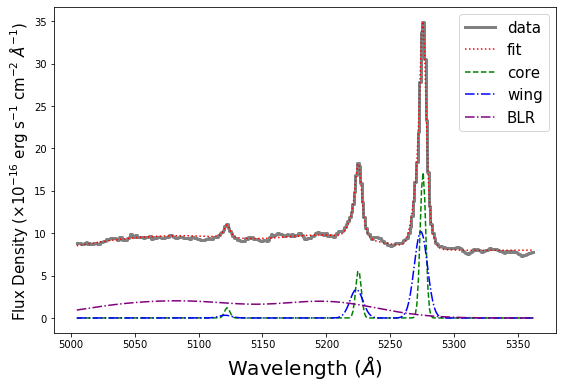

No handles with labels found to put in legend.


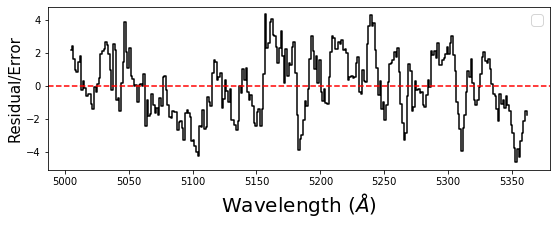

HE0021-1819
[4.286625987815945, 44.03606869212416, 15957.984876251765, 73.23578830270385, 1.2781180597061377, 8.725041759304052, 15825.404152399638, 297.41143978304854, 1.3254524396350114, 0.15578733766293568, 16007.103615907186, 1552.8067251370253, 0.0, 0.0, 15959.0, 1000.0, -0.900289220800235, 6.223351182859945, 132.58072385212654, 467.6524515304667, 40.752036042255874] [3.13216665e-02 8.49158393e-02 1.33152216e-01 2.75186596e-01
 2.07832627e-02 5.38959334e-02 9.56920310e-01 8.99732205e-01
 8.61342033e-03 6.14873698e-03 1.02240008e+01 1.08608925e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.77565296e-02 9.18687000e-02 9.85113553e-01 1.09729365e+00
 2.67818106e-03]


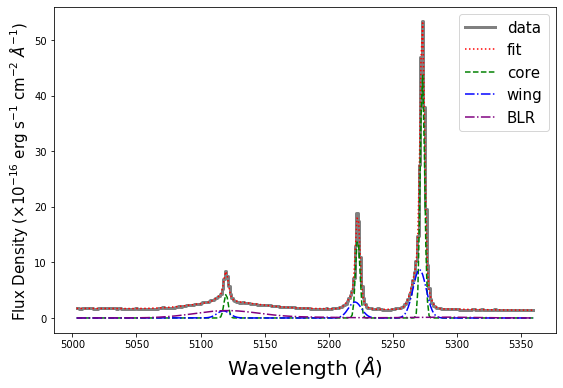

No handles with labels found to put in legend.


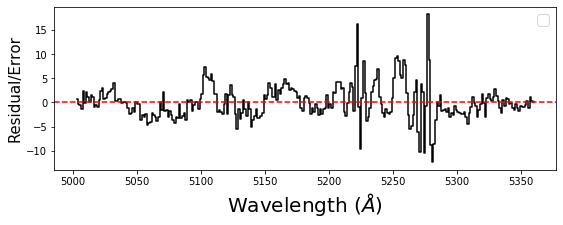

HE0040-1105
[7.8234832276517094, 85.94286409356891, 12568.038844730492, -67.05424609636154, 2.7016231505936656, 17.297990394767, 12470.687206973194, 251.82843418328656, 7.471311373741457, 0.8162695043833477, 12920.017102837719, 1172.342248591449, 0.0, 0.0, 12507.0, 1000.0, 0.8141442184940884, 0.24705836558511116, 97.3516377572978, 387.68730389710817, 41.1615588101869] [7.04445197e-02 1.64089865e-01 1.47472478e-01 2.95615809e-01
 4.94153875e-02 1.33719985e-01 9.69205968e-01 9.49006678e-01
 1.86218051e-02 1.06501192e-02 2.18338514e+00 2.71999021e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.09228600e-02 1.57584081e-01 9.78044257e-01 9.59470143e-01
 1.05709590e-03]


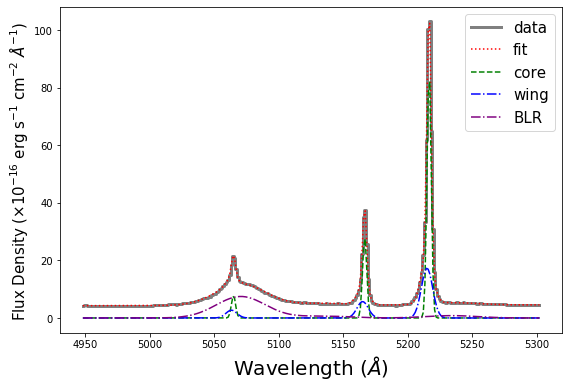

No handles with labels found to put in legend.


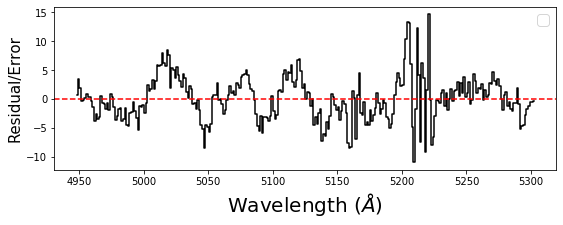

HE0108-4743
[39.23750980684097, 85.34035888691906, 7162.20280966623, 41.69349927923441, 4.144576662588297, 59.5557242791999, 7103.854981217815, 112.40899252812241, 5.925038552317779, 1.8055267098330305, 7035.406598386282, 1281.3326972799052, 20.66596030373056, 3.710656470546491, 7181.556307240954, 430.87103099629695, 2.3022106642406026, -0.049508698585538954, 58.347828448414475, 235.24534487349965, 40.942003077453734] [7.72361318e-01 3.28084941e+00 1.19055219e+00 2.17318473e+00
 9.63314881e-01 3.30879874e+00 2.38178766e+00 2.28333333e+00
 3.50252983e-01 1.12428664e-01 2.83807037e+01 4.47229813e+01
 2.67004764e-01 1.31766756e-01 3.08487052e+00 9.24033537e+00
 1.48372470e-01 7.56000855e-01 1.91304869e+00 2.18239607e+00
 2.78832578e-03]


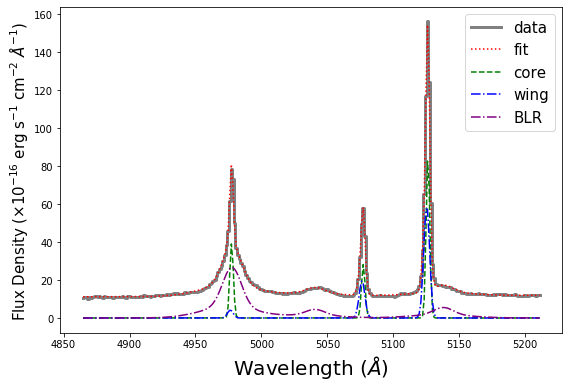

No handles with labels found to put in legend.


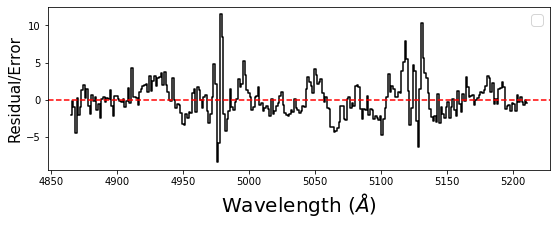

HE0114-0015
[9.49004680758341, 9.396339789022234, 13674.43099983812, 124.77444289234994, -0.13132264613174283, 0.6277728114102422, 13667.099698829676, 390.65109512546394, 1.7833455112870613, 0.5353495302825251, 13699.168335667626, 1196.487856196145, 0.0, 0.0, 13680.0, 1000.0, -0.23908159151410913, 2.5907549102410443, 7.331301008443916, 377.0694350028047, 40.628578298612005] [8.85453916e-02 6.70692909e-02 6.96644296e-01 1.12788805e+00
 1.06799939e-01 4.93861852e-02 2.35958791e+01 1.90705692e+01
 4.10299053e-02 1.28823142e-02 1.01708245e+01 1.86055173e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.53858962e-02 1.80998884e-01 2.39889612e+01 5.77260672e+00
 6.34943304e-03]


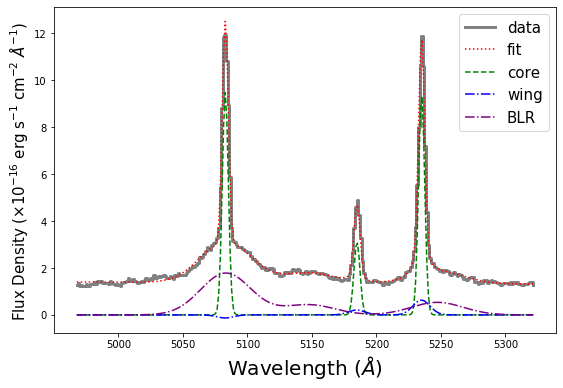

No handles with labels found to put in legend.


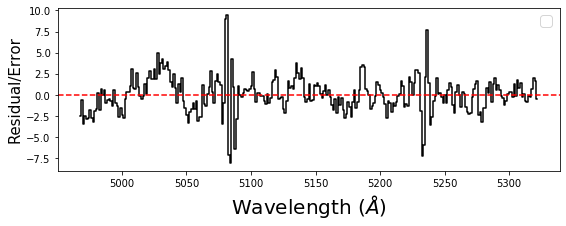

HE0119-0118
[18.05652934763961, 84.40959346308505, 16343.021176688615, 107.93512500793582, 1.2205179763419207, 65.33993258378095, 16133.361454227637, 241.4456399593577, 10.064871399674367, 0.11915193697506844, 16511.3781387321, 896.3722885529382, 10.634727247056283, 3.366388226798781, 16351.326659490158, 2390.0922998995397, -12.276429291658912, 79.98170079433905, 209.65972246097772, 544.434233059977, 41.995460163817604] [2.25939247e-01 9.17035101e-01 1.22647897e+00 1.32577592e+00
 2.66017673e-01 8.98307285e-01 2.51335293e+00 1.10394728e+00
 1.86407979e-01 8.23776490e-02 1.46899779e+01 2.66344282e+01
 2.57669735e-01 8.40341337e-02 2.36793377e+01 3.05903022e+01
 2.19589294e-01 1.15058515e+00 1.80043058e+00 1.58864820e+00
 2.45297423e-03]


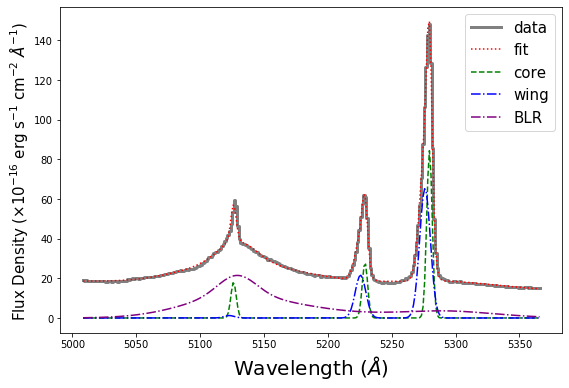

No handles with labels found to put in legend.


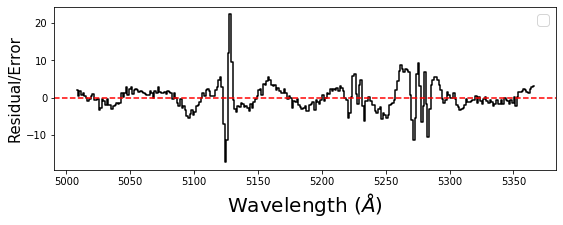

HE0212-0059
[4.7857896020562, 55.77838492432769, 7920.609856879457, 171.9973053812369, 0.48193366638671964, 5.605042191136068, 7641.041489800976, 439.79844829965214, 7.173622847854341, 2.3436057386956115, 6909.937642823234, 3898.3650853211793, 1.901425442146416, 0.8937333997524503, 4628.322205126144, 891.20910395945, 1.372942531859183, 0.5472745080704562, 279.56836707848106, 575.6090714012122, 41.28781586987089] [1.30462074e-01 2.28105575e-01 8.15871168e-01 8.92666900e-01
 2.68299765e-01 2.19159048e-01 1.65506790e+01 1.25731975e+01
 7.34479649e-01 2.58328633e-01 8.46178853e+02 5.77026829e+02
 1.41851827e+00 5.91920256e-01 7.11490824e+01 2.77637045e+02
 2.04303256e+00 1.07209478e+01 1.66501861e+01 5.52572425e+00
 5.09064677e-02]


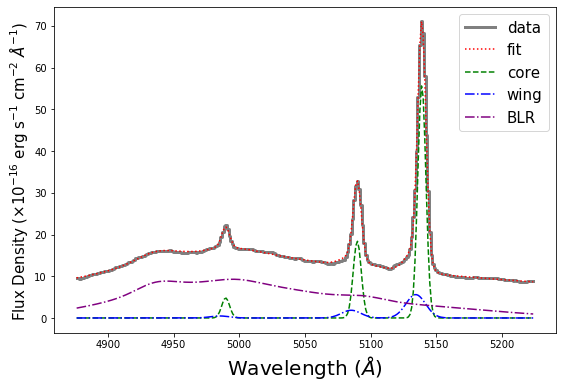

No handles with labels found to put in legend.


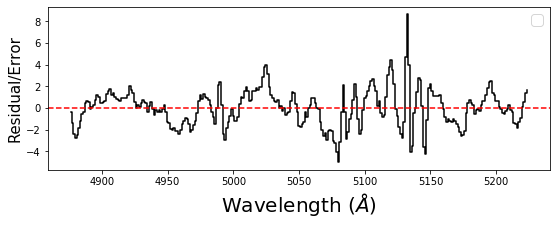

HE0224-2834
[5.062113526668549, 57.62821575712707, 17987.947395441683, 112.38693327644461, 1.756697364170308, 16.228916308462754, 17960.87798333259, 274.4444461046996, 6.862145104530566, 1.1306095225137085, 17980.89802491887, 2169.0976201598887, 0.0, 0.0, 0.0, 0.0, -1.8684118685314917, 17.140484927904733, 27.06941210909281, 418.37797708693415, 41.717911855012574] [9.68900152e-02 2.94863326e-01 2.10549780e-01 5.82787798e-01
 7.96220636e-02 3.15309300e-01 1.02782095e+00 2.06857437e+00
 1.37386959e-02 1.41298985e-02 4.51323608e+00 5.78295098e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.00380280e-02 2.61910698e-01 1.12879870e+00 8.94938035e-01
 1.19444615e-03]


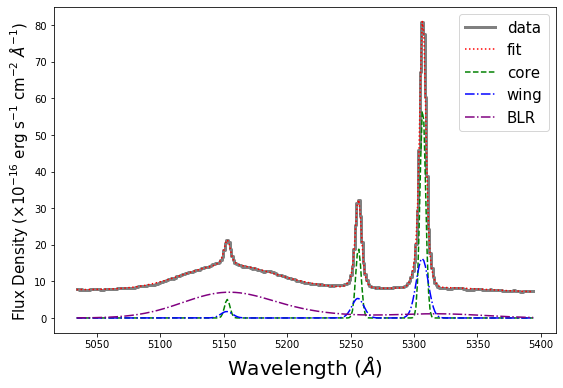

No handles with labels found to put in legend.


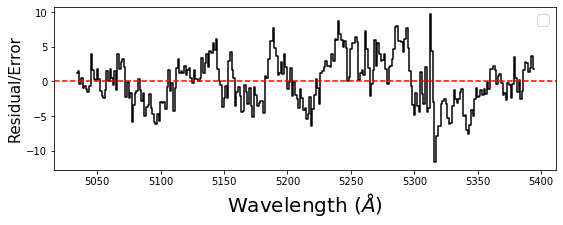

HE0227-0913
[50.39478116135774, 82.38604808647376, 4793.553331035825, 139.88152196686525, 28.334729525737306, 8.270655046934689, 4343.356757419057, 308.92634595035, 43.58125899213111, 6.769064610651495, 4712.5801324169215, 1342.210567189591, 97.23605138280907, 23.388145967277048, 4919.905252156186, 381.6979775087213, -8.858191605094522, 87.88744630442271, 450.19657361676764, 571.8028267155814, 41.3753153274322] [4.78967701e-01 1.79350087e-01 3.65871052e-01 4.83835037e-01
 3.03718753e-01 1.24395245e-01 4.86438610e+00 3.50710532e+00
 2.69046546e-01 8.85302745e-02 1.78796966e+00 4.99607929e+00
 3.03233402e-01 7.79120170e-02 1.02492576e+00 1.66092003e+00
 1.03794270e-01 5.23111362e-01 4.62252034e+00 3.77881227e+00
 6.38079421e-04]


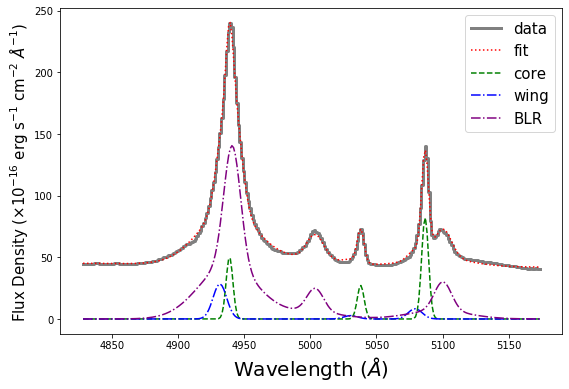

No handles with labels found to put in legend.


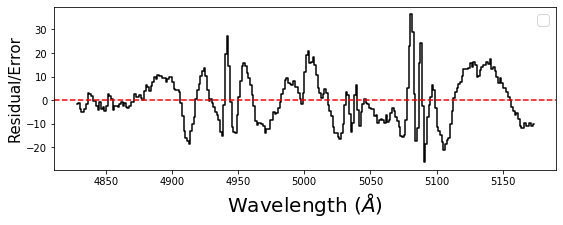

HE0232-0900
[62.60489470344349, 659.5789761200972, 12876.602035717888, 145.11318572459055, -0.26103469925363953, 162.88607794276209, 12840.898114658172, 326.74313268293923, 97.58582258313398, 14.255226583983744, 12915.830955012925, 2205.227560066641, 0.0, 0.0, 12942.0, 1000.0, -53.42983280163568, 375.84190271696656, 35.70392105971587, 498.5823362422624, 42.58408448153165] [1.38810182e+00 3.75086595e+00 3.31117611e-01 6.83991031e-01
 1.10028699e+00 3.89962446e+00 1.21725066e+00 2.82833952e+00
 2.42449540e-01 2.10212374e-01 6.06653374e+00 6.24560099e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.73135499e-01 3.48432241e+00 1.39357817e+00 1.11380993e+00
 1.24607453e-03]


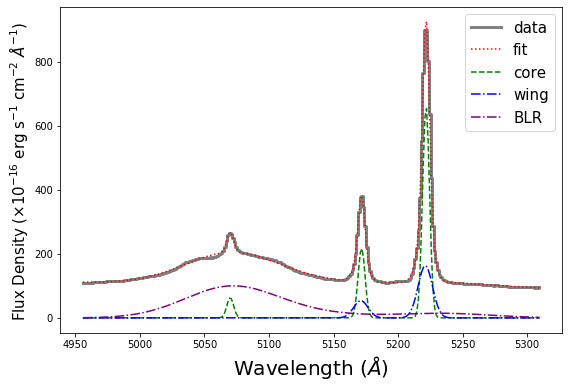

No handles with labels found to put in legend.


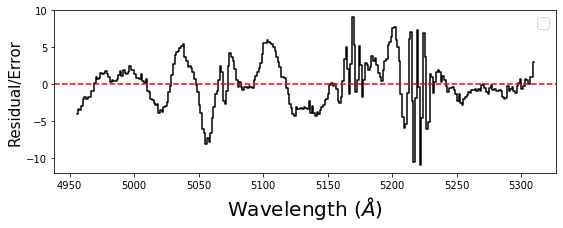

HE0253-1641
[19.37713991483664, 192.72195005457672, 9545.035994937349, -106.35049931068566, 9.71946857555091, 65.05873203457602, 9296.79678516554, 364.0634920947289, 25.90669021501949, 6.8948476916926404, 9726.76199962901, 564.101687878995, 14.992421311590872, 3.510320957699251, 9170.577689044207, 1730.0637424485853, -1.426574168783402, 47.22428305953107, 248.23920977180933, 709.7835592318589, 41.579813160113545] [2.48345597e-01 3.81180735e-01 3.09574527e-01 4.74951868e-01
 2.96888145e-01 3.54579050e-01 1.85095972e+00 1.44092061e+00
 2.22370196e-01 1.14750512e-01 4.13747611e+00 4.28081354e+00
 1.26568492e-01 1.29931001e-01 1.47851315e+01 1.18795976e+01
 1.72185687e-01 8.78018526e-01 1.68269867e+00 2.26749957e+00
 1.93770912e-03]


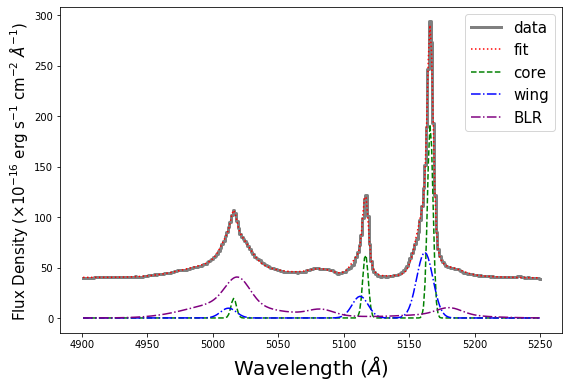

No handles with labels found to put in legend.


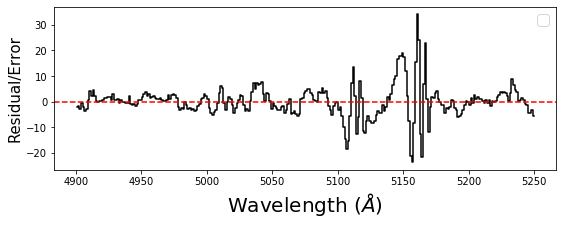

HE0345+0056
[14.63885843319615, 174.72299981103907, 9194.390144515428, 154.84854685587354, 42.96154572859178, 113.55111205924956, 8855.826951116922, 388.0947599659183, 85.2836579898631, 17.49134108031265, 9328.164479273046, 1534.6682364449114, 258.5843553240359, 24.61568392989923, 9343.187083071405, 325.24164479321985, -5.62091939616206, 110.83275909757418, 338.563193398506, 878.7273362734946, 42.28715000682509] [2.29525332e+00 9.23450387e-01 9.39519219e-01 1.26084941e+00
 9.21439337e-01 8.89586873e-01 2.81769126e+00 1.28719460e+00
 4.58971203e-01 1.60816347e-01 3.06577560e+00 6.72743982e+00
 1.68698653e+00 2.24818461e-01 1.70741754e+00 1.59912435e+00
 3.31048831e-01 1.69417003e+00 2.37903800e+00 2.22401718e+00
 1.00059364e-03]


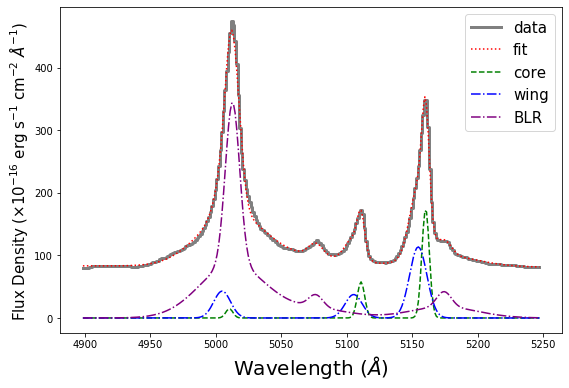

No handles with labels found to put in legend.


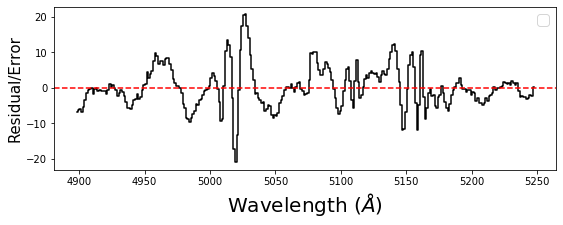

HE0351+0240
[18.85307441089585, 287.37012588428234, 10638.538083603955, 70.08446956105841, 7.662240436980076, 17.138525089454856, 10617.18428157681, 238.59158338289325, 10.80739630557291, 0.602774334061487, 11578.256270132955, 316.04970090364935, 26.062471557149475, 2.652950760794707, 10656.512719603454, 1304.9055514631582, -3.6066659006093724, 31.839868072338238, 21.35380202714441, 215.15140953175492, 41.66120850070456] [2.23430135e-01 5.92606958e-01 1.06869559e-01 2.64841073e-01
 1.86952079e-01 5.77842811e-01 1.36825506e+00 3.94229430e+00
 1.22830432e-01 5.37011373e-02 3.03592872e+00 3.51788156e+00
 1.08984292e-01 3.55391627e-02 3.37184930e+00 3.60376318e+00
 9.17016021e-02 4.71231317e-01 1.42320256e+00 6.39451965e-01
 6.06288076e-04]


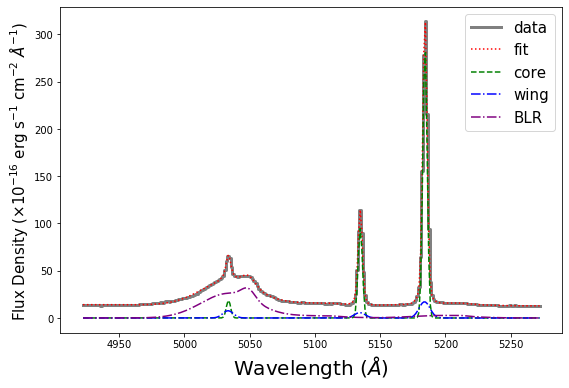

No handles with labels found to put in legend.


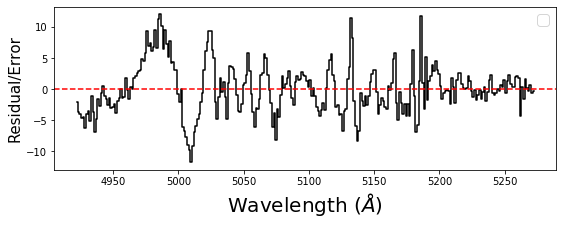

HE0412-0803
[88.29249387311913, 1218.6251999900196, 11476.237586087496, 80.33360595265096, 20.466765084537098, 176.95964769589978, 11454.520673871655, 251.97581846277782, 39.048024752629715, 6.2697195920781965, 11277.069646546403, 1793.3644049032914, 0.0, 0.0, 11448.0, 1000.0, -7.109703820094546, 60.71532947988276, 21.71691221584115, 304.74082719847763, 41.98614763859978] [2.98556884e-01 1.05316713e+00 5.88859606e-02 1.25446625e-01
 1.94006369e-01 9.00525778e-01 2.04531643e-01 4.90788788e-01
 4.41243047e-02 2.36547969e-02 1.59822194e+00 1.95269614e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.79706829e-02 3.50042381e-01 2.28166534e-01 1.13686838e-13
 3.67794118e-04]


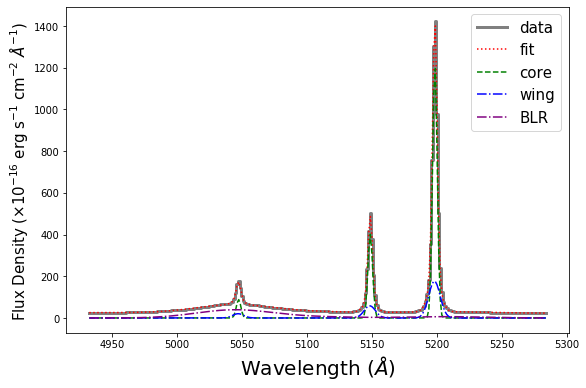

No handles with labels found to put in legend.


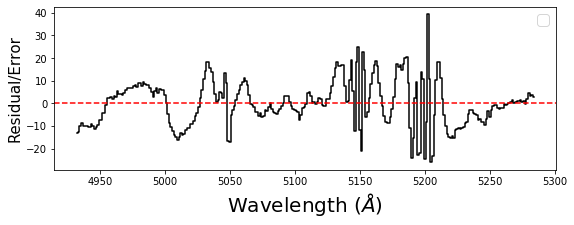

HE0429-0247
[15.818267062104995, 100.58292544373809, 12639.258492945783, 87.57099744421933, -4.332635857934912, 21.3688686823628, 12584.351100921598, 220.08048094554755, 19.049639705651373, 0.7028472501298925, 12652.629001340267, 427.6191493483312, 14.080328755381638, 1.7648721920548713, 12676.353589417435, 1605.4953827688166, -7.045602885241531, 50.276621049887254, 54.907392024184446, 320.8660293839565, 41.71393674006244] [2.00498415e-01 3.46021047e-01 1.94844913e-01 3.75066257e-01
 4.34204824e-01 3.62410866e-01 1.11131734e+00 1.31428614e+00
 2.72849090e-01 2.97351118e-02 1.61630155e+00 5.47556209e+00
 9.69479327e-02 2.73197691e-02 3.01695159e+00 7.24142838e+00
 6.09857176e-02 3.12580774e-01 1.16776289e+00 7.71481993e-01
 1.09057764e-03]


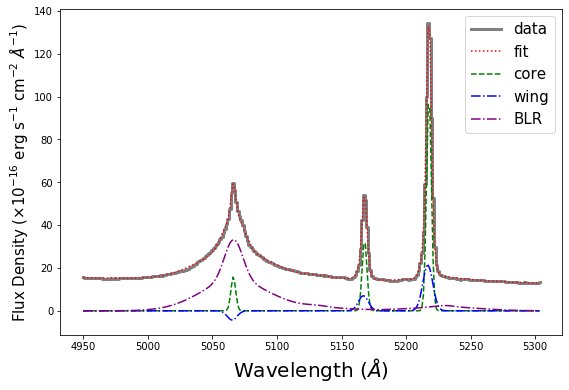

No handles with labels found to put in legend.


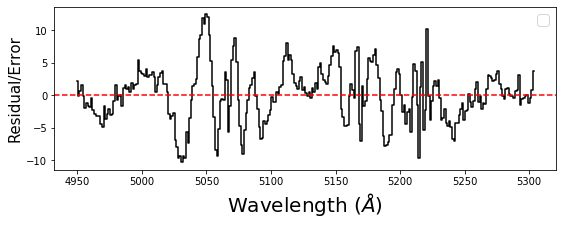

HE0433-1028
[13.498309495582456, 82.0036724538741, 10588.868384256855, 128.10886151673859, 8.456291212671625, 88.97986599729782, 10276.462509524117, 335.30436332023555, 41.2375142887152, 4.2339599172191456, 10497.132697547311, 921.657146942224, 21.28951494125379, 5.680434608820318, 11223.443685503507, 2035.0957234836976, -16.914746969820914, 117.31100961689863, 312.4058747327381, 795.0174677777848, 41.98754116867506] [1.92185759e-01 3.53764176e-01 7.33948157e-01 9.37176870e-01
 2.51168084e-01 3.50369737e-01 1.15476315e+00 5.22302504e-01
 1.80794314e-01 7.45884916e-02 2.49986006e+00 5.59321440e+00
 2.56358453e-01 9.06143150e-02 1.08744623e+01 7.50732084e+00
 1.37950033e-01 6.89864200e-01 9.15378688e-01 1.01546579e+00
 6.36846649e-04]


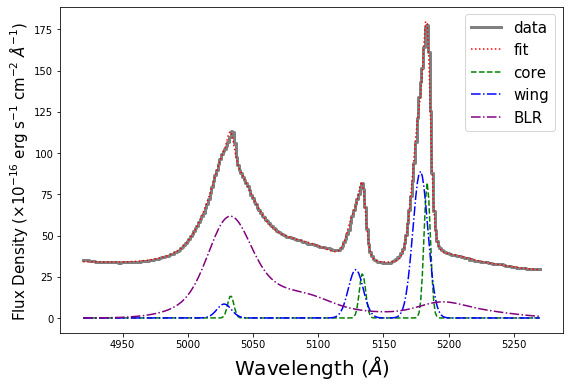

No handles with labels found to put in legend.


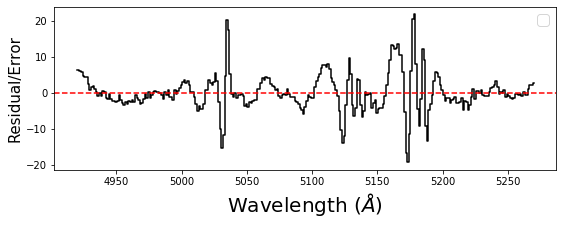

HE0853+0102
[2.427306463873265, 14.410905670068086, 15712.721842731287, 102.26861774583334, 0.34916479274548784, 4.350809987164156, 15681.591594659745, 298.1494725195376, 1.57959428415521, 0.12482271927749256, 17060.951225158908, 1119.5659535631708, 1.6164353085866434, 0.3119796139444427, 15126.50986883897, 1412.2467311424077, -0.0313280076443602, 1.3098154870669474, 31.130248071542155, 470.46283215550983, 41.02524133185252] [4.59487447e-02 9.87120859e-02 4.36684867e-01 8.69108689e-01
 4.26150424e-02 1.03047216e-01 1.63770157e+00 3.72642178e+00
 1.10115618e-01 9.69520035e-02 9.52850826e+02 1.53149870e+02
 1.22854740e-01 9.96633473e-02 9.71009849e+02 1.50641731e+02
 2.37708672e-02 1.22347584e-01 1.84206569e+00 2.46158653e+00
 2.19414202e-03]


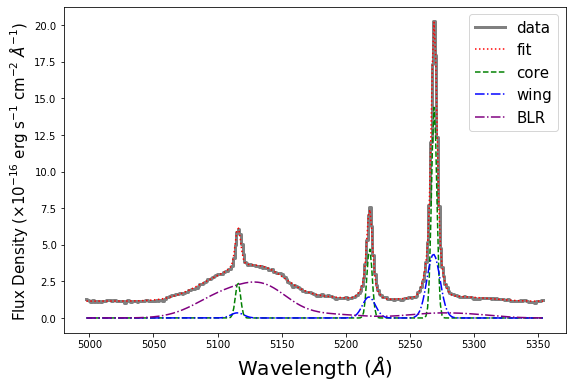

No handles with labels found to put in legend.


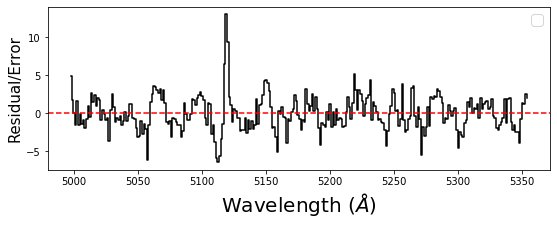

HE0934+0119
[8.286278726499965, 49.52415417049359, 15207.052731463187, 72.69407750471247, 4.136346630767625, 22.311137489056893, 15076.66602344673, 168.19078410905178, 21.320016384115423, 3.0418949753222244, 15203.482608797496, 572.0374649611216, 9.11358996524406, 0.5032636297782367, 15199.713290594773, 1485.8783971046369, -3.852104037486194, 33.88683447953653, 130.3867080164564, 346.8450592339227, 41.7986290077676] [1.25358542e-01 3.12247999e-01 3.53654142e-01 5.57722971e-01
 1.27031500e-01 2.70641254e-01 1.82337856e+00 6.72694904e-01
 8.47008820e-02 2.70368772e-02 1.07547544e+00 3.12741965e+00
 1.16756178e-01 3.15238747e-02 2.60959117e+00 9.72268740e+00
 5.58604207e-02 2.88816883e-01 1.81099300e+00 8.06764781e-01
 6.31348294e-04]


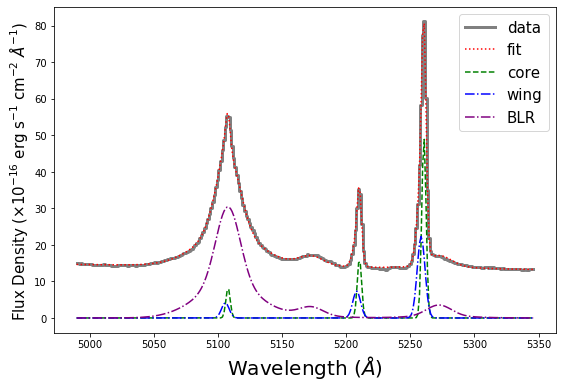

No handles with labels found to put in legend.


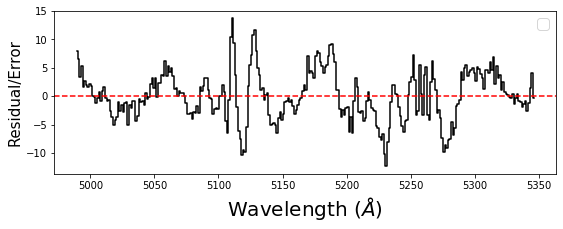

HE1011-0403
[5.679560250554006, 32.08184532672064, 17534.893712734636, 100.02782172331572, 2.7635613631553273, 16.628925824676713, 17313.593001568395, 256.7114554548123, 6.569155042965622, 0.3239135869786792, 17809.568357552558, 1831.8459636923594, 22.59495628469939, 3.0796703343687493, 17676.80483687451, 823.2528416149622, -0.03264532738966647, 21.095443410763075, 221.30071116624094, 550.3167540393599, 42.00723560604662] [1.26677759e-01 2.18663987e-01 5.18630946e-01 8.95526823e-01
 1.07986045e-01 1.66214439e-01 2.85878997e+00 1.25203018e+00
 2.03044000e-01 7.28160614e-02 7.25283713e+00 2.50599207e+01
 1.73032674e-01 5.10089794e-02 2.36818856e+00 5.18111458e+00
 1.14747345e-01 5.90861656e-01 2.80902780e+00 1.71050666e+00
 9.38665606e-04]


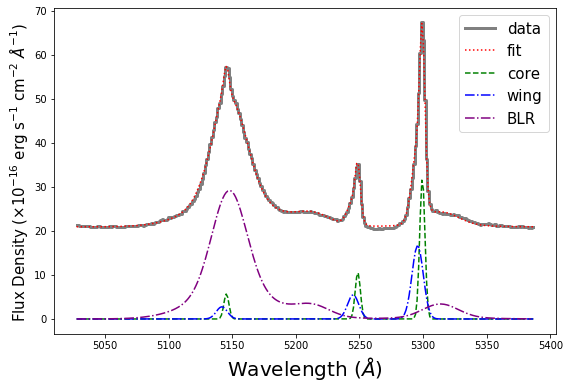

No handles with labels found to put in legend.


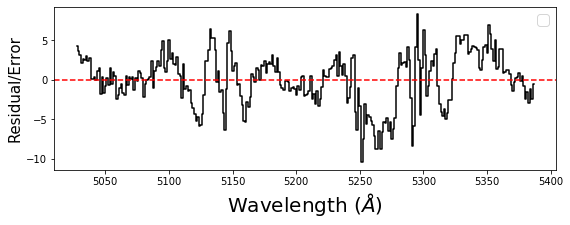

HE1017-0305
[2.4187614120826706, 32.11054493587067, 14681.698356793835, 55.214644642593285, 2.132620041360495, 11.966606972980877, 14629.200527860428, 202.77732218814447, 15.88338915388772, 1.7105429087445225, 14471.684393186084, 1951.743275433707, 0.0, 0.0, 14995.0, 1000.0, -9.497330473077726, 63.80171233738908, 52.49782893340671, 366.3637796186606, 41.87441943377927] [1.94742565e-01 4.40621901e-01 5.31017629e-01 1.56080800e+00
 1.37938169e-01 4.59408495e-01 2.22295056e+00 4.04050599e+00
 3.11839248e-02 3.11768708e-02 3.92470199e+00 4.99506564e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.99955383e-02 5.20036641e-01 2.22111254e+00 3.62320178e+00
 1.09207842e-03]


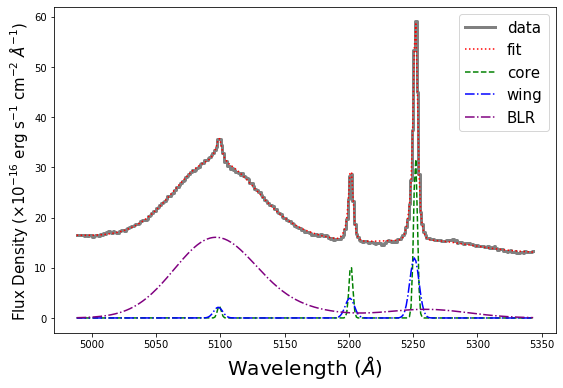

No handles with labels found to put in legend.


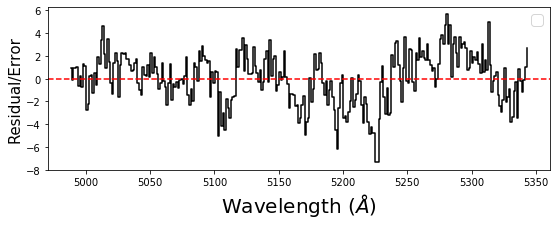

HE1029-1831
[27.454854323789995, 8.289432728444677, 12121.291545072665, 72.18635426939773, 6.585131899061019, 39.883757930100906, 11987.388524295884, 217.16035718745735, 6.062687713586677, 1.9967767300402448, 11965.0962260633, 1623.130402912297, 8.331781018778745, 0.8584218047130702, 12591.074288497652, 859.3010709366221, -3.6820577540187283, 29.468309000290095, 133.90302077678098, 520.6994570327379, 41.41850246344332] [1.78944570e-01 2.68019112e-01 1.23491379e+00 1.19465299e+00
 5.69397308e-01 1.98571487e-01 8.57120491e-01 7.21929230e-01
 7.47528741e-01 1.74456468e-01 4.73001996e+01 5.71096281e+01
 6.60957431e-01 2.06902686e-01 6.50521524e+01 7.54392424e+01
 9.55571799e-02 5.02444233e-01 1.59100790e+00 1.70478944e+00
 5.74334930e-03]


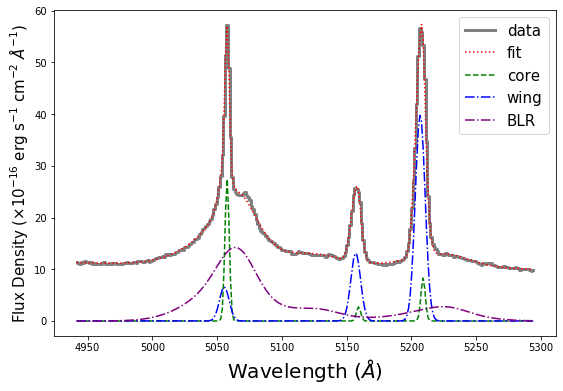

No handles with labels found to put in legend.


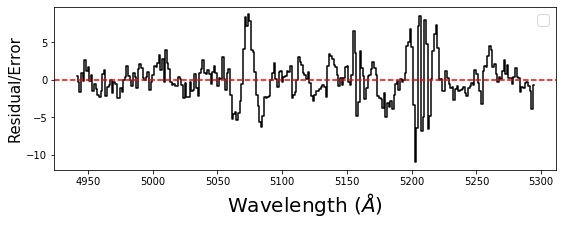

HE1107-0813
[2.1570123043166682, 7.928360951495604, 17550.151554482967, 77.77647234941139, 5.288750184835077, 2.839770299538007, 17425.47358828497, 504.93262911455906, 17.798807662848645, 7.079506357080842, 17568.567397393934, 1055.8095735426368, 16.887659388242405, 2.376984287260009, 16748.496738764767, 1952.993921406001, -26.665484732746012, 199.15982844551874, 124.67796619799628, 1019.4075565959728, 42.23083510889571] [1.61175325e-01 1.07178184e-01 1.41001656e+00 2.45021457e+00
 1.56012349e-01 7.64657923e-02 7.13849779e+00 1.04494917e+01
 4.39730459e-01 9.33215408e-02 5.34305229e+00 1.13361325e+01
 3.60302858e-01 8.58387572e-02 2.19979726e+01 9.75420785e+00
 1.05526374e-01 5.59698956e-01 7.47975806e+00 2.44427080e+01
 1.10263390e-03]


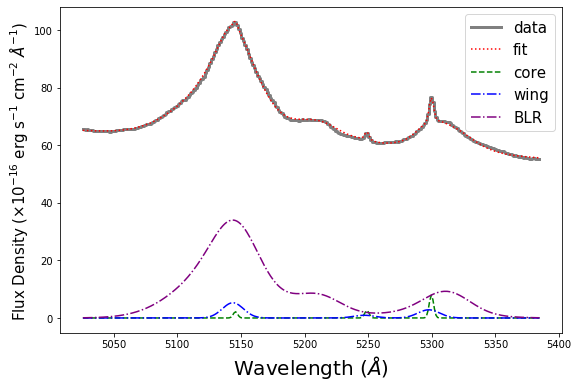

No handles with labels found to put in legend.


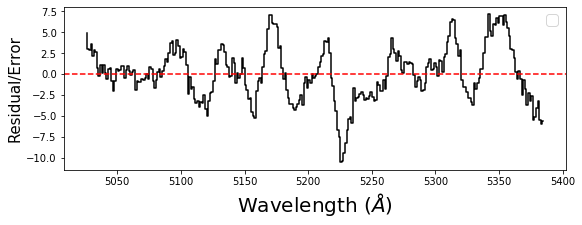

HE1108-2813
[27.105428799606074, 45.11123832645942, 7169.083504955203, 67.85810214903162, 11.637683835601413, 26.897964592164065, 7051.6747900086675, 236.92504342284278, 16.460639820722413, 4.64152642195189, 7353.615399701936, 1302.6679794875997, 0.0, 0.0, 7200.0, 1000.0, -6.327929811295385, 52.478521898623946, 117.40871494653584, 492.6830627734706, 41.06002470652891] [2.03625277e-01 3.18574192e-01 6.22820234e-01 9.60567765e-01
 1.90525569e-01 3.36830948e-01 1.26515097e+00 1.72155660e+00
 4.50798203e-02 2.90246362e-02 3.25183490e+00 3.12789871e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.13554507e-02 4.11768740e-01 1.18053756e+00 2.33221341e+00
 1.03312467e-03]


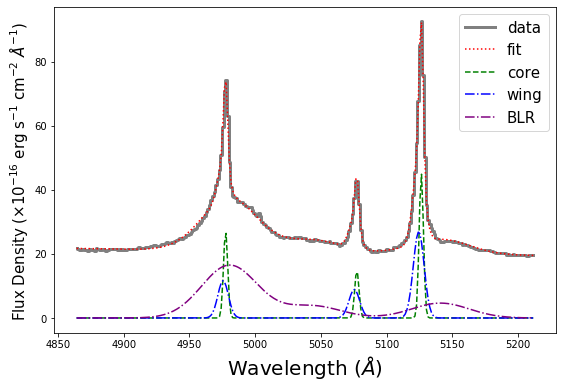

No handles with labels found to put in legend.


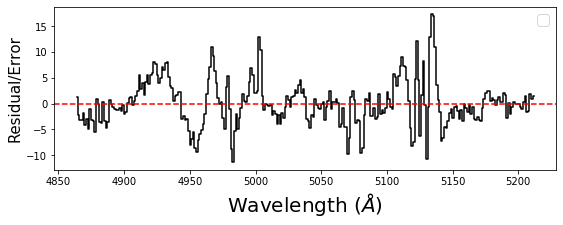

HE1126-0407
[9.82832424701998, 116.53027025682805, 18035.809808661317, 114.35018003874384, 18.74338430758337, 22.248395412595762, 17774.383266264336, 344.1731688078263, 74.1659964447457, 9.239049884481847, 18072.647394755102, 720.611332226292, 54.105378611740235, 12.822948778019446, 17968.09832907508, 1806.8738927870097, -12.29923432125887, 136.10315429907985, 261.42654239698095, 583.4093581179086, 42.755808589078626] [6.65859414e-01 6.57920810e-01 6.67325511e-01 8.88200278e-01
 8.18062111e-01 4.57176705e-01 7.90932104e+00 5.20611733e+00
 7.16702528e-01 1.96517857e-01 3.25800919e+00 7.28372780e+00
 7.62688794e-01 2.25664987e-01 6.13684496e+00 1.21689688e+01
 3.25204368e-01 1.70775196e+00 7.74818391e+00 6.96926304e+00
 1.08464811e-03]


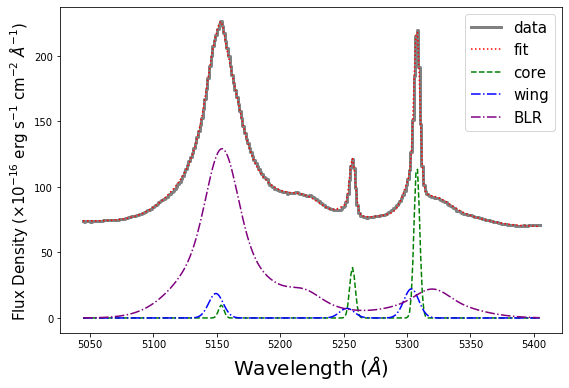

No handles with labels found to put in legend.


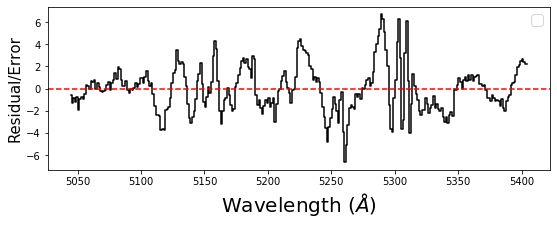

HE1237-0504
[19.49384939430773, 224.662972450727, 2489.6198977155605, 103.76866683337883, 13.476356438642508, 35.68056179272398, 2303.355642379843, 307.4756631888568, 37.87462858096604, 9.794897553036694, 2453.3878734031578, 1679.569744065161, 0.1, 0.1, 2700.0, 1000.0, -2.6589024600995352, 24.09436315341981, 186.26425533571728, 478.6354779606336, 40.670568021145115] [8.68451109e-02 1.45039297e-01 8.41861523e-02 1.05765555e-01
 6.03154118e-02 1.14713660e-01 5.76658218e-01 5.49245750e-01
 2.29023414e-02 1.28166897e-02 7.81178598e-01 9.96395242e-01
 2.77555756e-17 2.77555756e-17 0.00000000e+00 0.00000000e+00
 3.58459762e-02 1.79730386e-01 5.45955000e-01 6.48238905e-01
 2.11097121e-04]


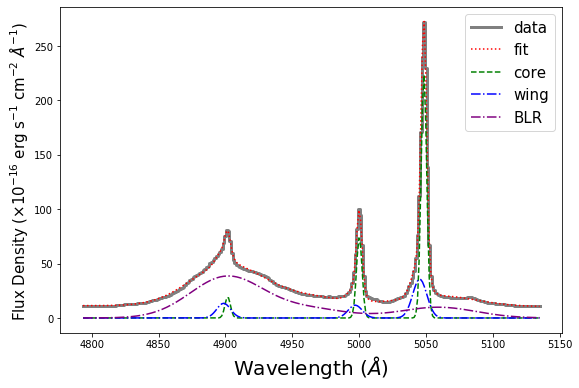

No handles with labels found to put in legend.


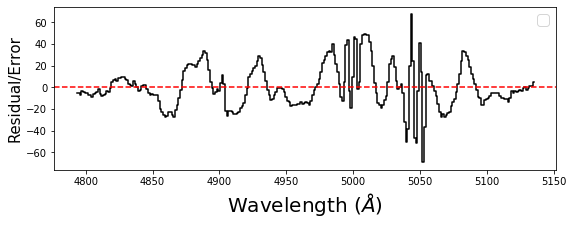

HE1248-1356
[12.177153909313787, 73.38919844246432, 4290.981947833095, 57.18980838137494, 1.6081078501923785, 12.682163517428599, 4257.976993473392, 207.1069236564922, 2.095038401977717, 0.6254753738934877, 4271.4595805843155, 1711.4304239757535, 0.0, 0.0, 0.0, 0.0, -0.131243121496996, 0.9795410868456687, 33.004954359702424, 282.2751507919763, 39.848546934847334] [1.36499384e-01 3.49255737e-01 1.91060363e-01 5.27620384e-01
 1.25542263e-01 3.54236466e-01 1.45645831e+00 2.86219246e+00
 2.81003780e-02 2.11515341e-02 2.84174138e+01 3.57021114e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.41067963e-02 2.77297025e-01 1.53547758e+00 1.55990369e+00
 6.33167877e-03]


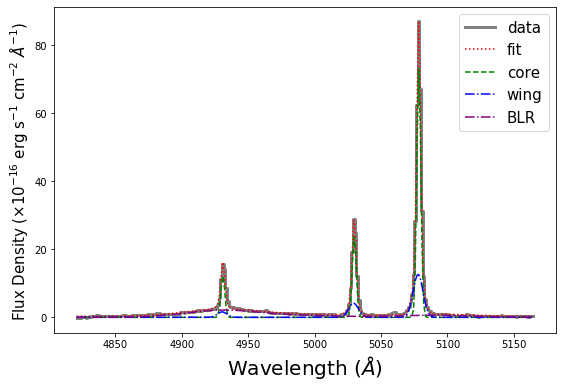

No handles with labels found to put in legend.


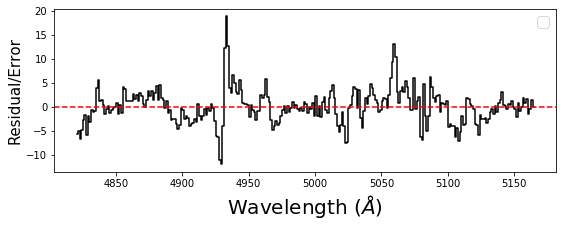

HE1330-1013
[3.8218921486267234, 16.189644296556395, 6751.492525381073, 72.72502823229266, 2.1768719448573015, 4.019371418712531, 6610.988554001032, 223.72886433227637, 2.8979687275656847, 1.2687829684053438, 7006.152513832253, 2060.1450409322183, 6.972239192980408, 0.8650183824154536, 6833.816055304659, 673.1740308979133, -3.715326609840787, 24.172854416696296, 140.50397138004155, 400.9632821701861, 40.68531410137176] [1.04104113e-01 1.41852629e-01 7.20713480e-01 1.23677226e+00
 1.05558240e-01 1.43194559e-01 5.65444559e+00 3.28384505e+00
 3.74976563e-02 2.45150139e-02 1.41376896e+01 1.99510946e+01
 6.05205249e-02 2.19616215e-02 4.87102837e+00 4.79415537e+00
 6.33820661e-02 3.18297757e-01 5.65800208e+00 3.84326115e+00
 2.00417320e-03]


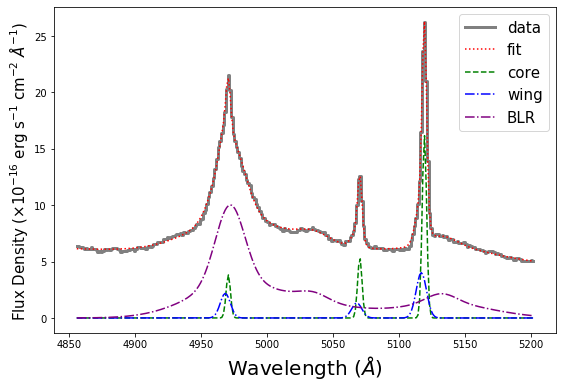

No handles with labels found to put in legend.


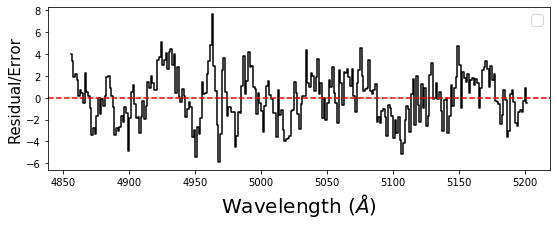

HE1353-1917
[5.236483609050953, 46.45256642216187, 10498.054886325122, 92.87394356771547, 1.0852776957030066, 6.600018061791628, 10303.333663655543, 370.2240269467084, 2.768460085151171, 0.6777145235661884, 8417.494541806254, 1482.6017995516875, 2.684236617141625, 0.18571713021213193, 11786.689880334721, 2054.632082909921, -3.2049989381443917, 29.092611258101567, 194.72122266957922, 541.860755807699, 41.04750225132186] [6.30871142e-02 1.05650461e-01 2.50576373e-01 4.02085539e-01
 5.11446915e-02 7.43120889e-02 3.34193303e+00 3.00320387e+00
 7.59104103e-02 2.36887873e-02 2.77262328e+01 2.59625206e+01
 4.18833184e-02 3.01193469e-02 5.63070663e+01 3.67354475e+01
 1.10620169e-01 5.61667579e-01 3.37497511e+00 4.01380379e+00
 3.04849560e-03]


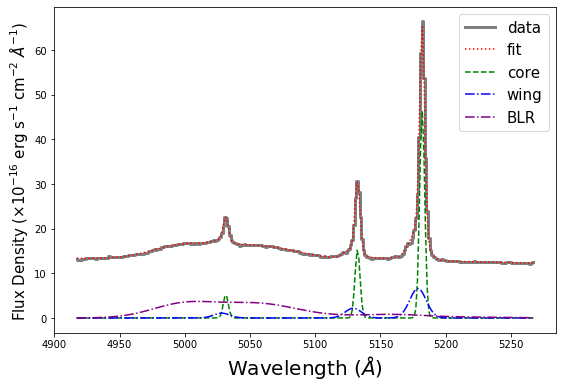

No handles with labels found to put in legend.


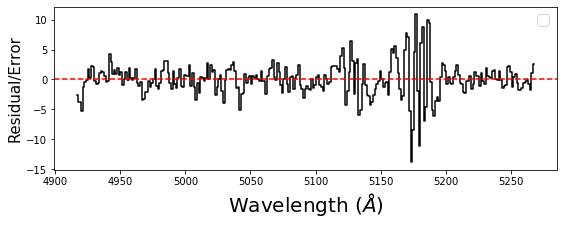

HE1417-0909
[6.8990002889940145, 96.49862972704024, 13083.967883574178, 61.39502685709795, 1.5821376498834476, 20.02777955527522, 13049.99795461631, 180.14277188392848, 10.572939881765818, 1.1863278630484684, 13223.08755447347, 1460.0794150406964, 0.0, 0.0, 13200.0, 1000.0, -6.416878750204032, 41.38622777799192, 33.96992895786752, 253.67798644972024, 41.45635710554571] [1.74780881e-01 5.83890945e-01 2.29868561e-01 5.72932311e-01
 1.28732748e-01 5.98772595e-01 9.75273325e-01 2.05691276e+00
 2.82031152e-02 1.63203807e-02 3.12875543e+00 4.61287805e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.04359215e-02 2.60486190e-01 1.02988635e+00 1.14066748e+00
 1.02418406e-03]


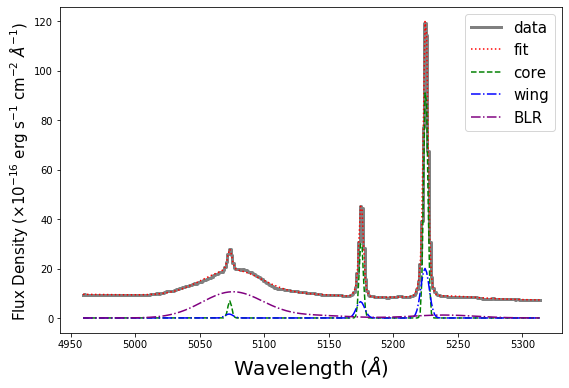

No handles with labels found to put in legend.


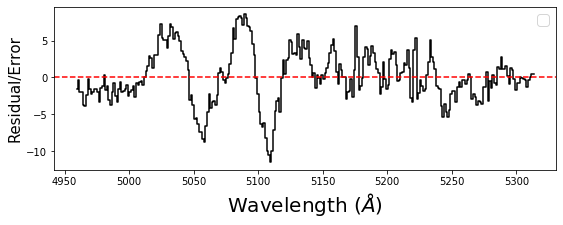

HE2128-0221
[4.2967555930284735, 38.425863788474466, 15756.518753401653, 50.315486306443354, 3.9668680402794236, 11.556876773709128, 15724.475593555811, -140.61480520389588, 5.25913069324259, 0.6418794238600051, 15833.959791548157, 885.7131927955724, 0.0, 0.0, 15744.0, 1000.0, -0.4079330111033193, 6.01099918167622, 32.04315984584173, 224.3072862731329, 41.09355853011274] [1.43879597e-01 4.01945446e-01 3.41507539e-01 7.73743930e-01
 1.21102874e-01 4.33153868e-01 9.40242051e-01 1.83095173e+00
 2.50908588e-02 7.02475187e-03 2.42300633e+00 3.97142656e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.42566716e-02 1.26212541e-01 1.02245539e+00 1.26278586e+00
 1.40320426e-03]


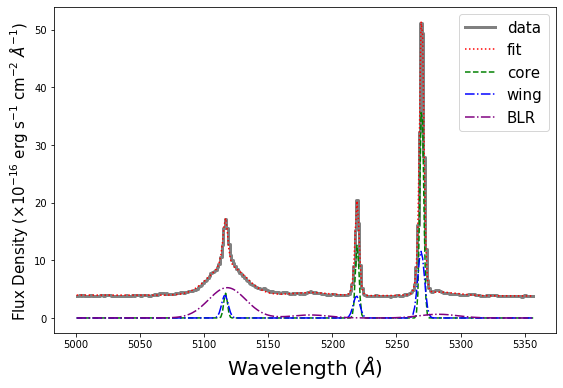

No handles with labels found to put in legend.


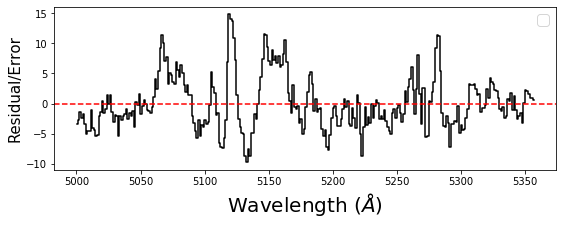

HE2211-3903
[7.895252619975066, 42.47365865074545, 11860.998064119744, 68.43080599199665, 0.46950258184267996, 3.78404075866002, 11761.586303465205, 210.4983337257395, 4.5745831726004305, 0.7078376354141895, 11551.672402067214, 2643.135714851405, 0.0, 0.0, 11914.0, 100.0, 0.530260290062821, 8.187061526910867, 99.41176065453874, 233.97699170727444, 41.26024885777717] [6.49488221e-02 1.12413210e-01 1.99472965e-01 3.52301615e-01
 4.51191702e-02 1.19681235e-01 3.24405812e+00 3.68614799e+00
 1.04875436e-02 1.31232105e-02 8.39179496e+00 8.22626993e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.44057104e-02 2.28720469e-01 3.23864111e+00 1.17066540e+00
 1.68684235e-03]


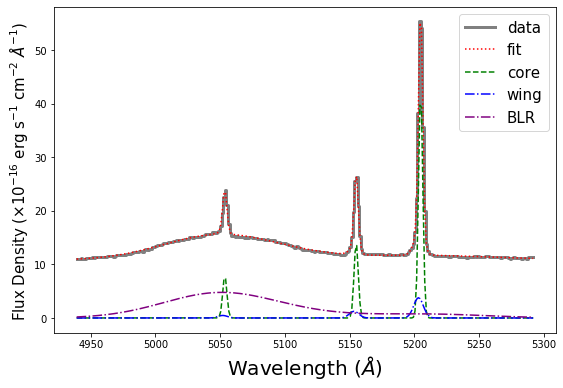

No handles with labels found to put in legend.


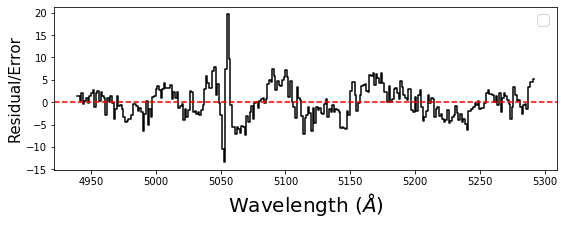

HE2222-0026
[2.4606044963524556, 7.634605845663457, 17417.941784240225, 120.3479052423, -0.1813974442375107, 3.0701234485006728, 17251.72908375276, 235.77930423334956, 2.6311306139373793, 0.20930402409207235, 18542.818218918976, 614.8139006842489, 3.7483925657580968, 0.5725183783513883, 17452.686869194556, 1680.0886596840828, -0.10196729994441601, 3.8912942813517932, 166.21270048746374, 466.17128015592715, 41.4321660941988] [6.92540068e-02 3.77024996e-01 4.51545739e+00 4.52416056e+00
 9.53986005e-02 4.11430603e-01 1.53575741e+01 1.24489504e+01
 5.93676885e-02 1.81360134e-02 5.26405379e+00 1.21418984e+01
 5.32900369e-02 2.29463786e-02 2.28820092e+01 6.90043847e+00
 2.76940111e-02 1.44103591e-01 1.14710091e+01 9.75606023e+00
 1.42970174e-03]


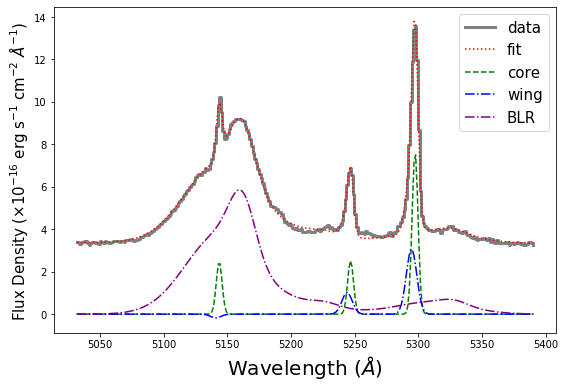

No handles with labels found to put in legend.


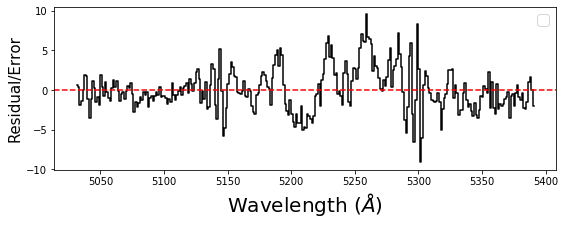

HE2233+0124
[1.028761079532159, 8.218660104925148, 16983.89776463816, 165.56296847137438, 0.319095294367742, 1.3519465482905015, 17029.02999152892, 503.43301309593403, 1.1264098990378497, -0.026011083478111284, 15217.721509618466, 1398.7911654718534, 1.8829498506767246, 0.23137795290009813, 18237.412794968546, 4351.169884389512, -0.5087456155347706, 4.917545789334459, -45.13222689076065, 630.6722124859969, 41.48587385488785] [6.90914889e-02 1.86369178e-01 1.54717096e+00 3.87092056e+00
 7.73792911e-02 1.92677472e-01 1.34301551e+01 4.14584549e+01
 5.01987778e-02 2.41492038e-02 5.84123685e+01 5.34424966e+01
 5.54779871e-02 5.42148912e-02 1.56662086e+02 1.22455265e+02
 2.51105476e-01 1.31719065e+00 1.41513482e+01 1.97301192e+01
 1.67606194e-02]


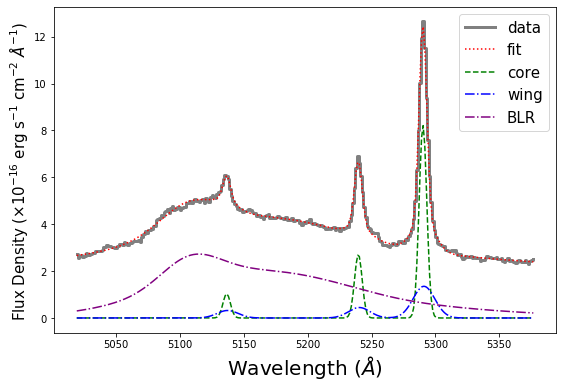

No handles with labels found to put in legend.


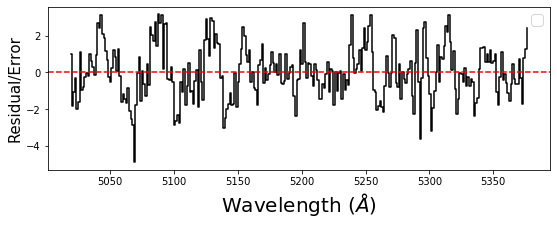

HE2302-0857
[30.08125075371935, 263.4915852081613, 14102.405012933865, 174.78361692454274, 5.234420820727908, 50.4264020928591, 14272.099786366725, 443.97703620906793, 12.465653653818647, 0.580439422201921, 15513.985182493981, 1399.4338046978553, 21.789736064188695, 7.5818140724399505, 12827.562641126544, 2106.3011612081536, -10.076688456785302, 88.0473440529682, -169.69477343286053, 647.9161898983132, 42.12662535525512] [3.86004021e+00 2.56844705e+01 1.28942816e+01 1.91383121e+01
 4.74176826e+00 3.16033639e+01 2.54765780e+01 4.48263610e+01
 1.51164114e+00 5.72448312e-01 1.06424968e+02 1.53730059e+02
 9.06216995e-01 7.90166663e-01 1.21609832e+02 3.00622838e+01
 6.04058792e-01 3.18118212e+00 1.31034047e+01 1.74752994e+01
 1.03947985e-02]


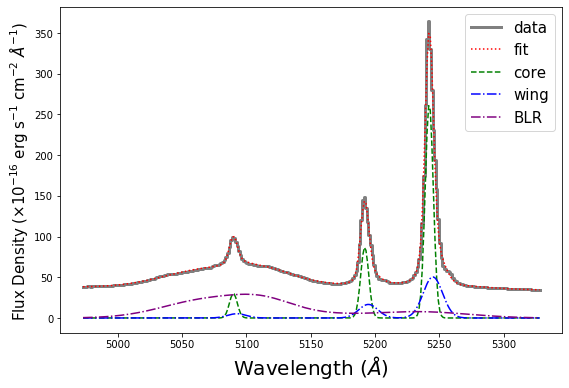

No handles with labels found to put in legend.


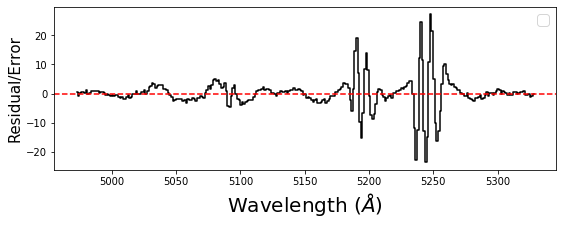

In [8]:
z = {"HE0021-1810":0.05352,"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}

objs = z.keys()

broad2= {'HE0021-1810':False,'HE0021-1819':False,'HE0040-1105':False,'HE0108-4743':True,'HE0114-0015':False
        ,'HE0119-0118':True,'HE0212-0059':True,'HE0224-2834':False,'HE0227-0913':True,'HE0232-0900':False
        ,'HE0253-1641':True,'HE0345+0056':True,'HE0351+0240':True,'HE0412-0803':False,'HE0429-0247':True
        ,'HE0433-1028':True,'HE0853+0102':True,'HE0934+0119':True,'HE1011-0403':True,'HE1017-0305':False
        ,'HE1029-1831':True,'HE1107-0813':True,'HE1108-2813':False,'HE1126-0407':True,'HE1237-0504':False
        ,'HE1248-1356':False,'HE1330-1013':True,'HE1353-1917':True,'HE1417-0909':False,'HE2128-0221':False
        ,'HE2211-3903':False,'HE2222-0026':True,'HE2233+0124':True,'HE2302-0857':True}
#'HE0021-1810':False,
p_init= {'HE0021-1810':[1.2078169642715146, 17.216305909165907, 16109.438508035631, 109.45461271403255, 0.3200326636674963, 10.221646289889714, 16011.042931381086, 299.0455462447658, 1.2124073142121425, 1.8963130746612582, 10860.525666229707, 2396.6708995937574, 0.0, 0.0, 15959.0, 1000.0, 1.1610606174311213, 1.7778000884751866]
        ,'HE0021-1819':[1,12.5,15959,50.0,3,3,15759,200.0,2,2,15959,1000.0,0,0,15959,1000.0,-0.001,0.1]
        ,'HE0040-1105':[1.139,1.5,12507.0,-50.0,1.0,3.0,12307.0,100.0,1.0,1.0,12507,1000.0,0,0,12507,1000.0,-0.001,2.0]
        ,'HE0108-4743':[39.237577877692715, 85.34149337269689, 7162.202253621596, 41.6939380680647, 4.144422236073521, 59.5545447193721, 7103.854580346932, 112.41008405668497, 5.925049122295072, 1.8055104262291544, 7035.4076987966255, 1281.3329615128491, 20.665960946360045, 3.710669187171524, 7181.556480474573, 430.8707020614182, 2.3022448079835613, -0.04967981643135043,]
        ,'HE0114-0015':[0.1,1.5,13680,120.0,1.0,3.0,13480,350.0,1.0,1.0,13680,1000.0,0,0,13680,1000.0,-0.001,0.3]
        ,'HE0119-0118':[18.05660859811562, 84.4095920594828, 16343.021367740042, 107.93509209640831, 1.2207224297067296, 65.33996725221164, 16133.361326639886, 241.44542909661888, 10.064952589397885, 0.11922164437143162, 16511.393117676984, 896.3989433325039, 10.634478954988479, 3.3663405963934196, 16351.30789876013, 2390.1171038535563, -12.276316410607894, 79.98110082727592]
        ,'HE0212-0059':[4.785770185809503, 55.77832394058257, 7920.6098244217255, 171.99703901261174, 0.4820655003901233, 5.605123767462352, 7641.049621205695, 439.79913411981, 7.173470331655197, 2.3435094620198083, 6910.053929265311, 3898.3687119322854, 1.901552737188031, 0.8937136428732486, 4628.357538385874, 891.2555075435819, 1.3723940319852157, 0.5501397045686803]
        ,'HE0224-2834':[7.06899403e+00,7.13458601e+01,1.79847558e+04,1.18000676e+02,1.45515224e+00,1.90068487e+01,1.79693125e+04,2.72340813e+02,8.44672986e+00,9.16885096e-01,1.80245745e+04,2.16641488e+03,0,0,0,0,-2.79613744e+00,2.29434665e+01]  
        ,'HE0227-0913':[50.394679609204886, 82.38595301209206, 4793.553851128582, 139.88069655713375, 28.334366378774646, 8.270912161070783, 4343.3627305096015, 308.9287526642564, 43.58112286442538, 6.768950196643075, 4712.578629985357, 1342.2135348231159, 97.23593356125787, 23.388212689292676, 4919.903960937358, 381.7006010971896, -8.85811095519379, 87.8870426811849]
        ,'HE0232-0900':[62.605607017687824, 659.5795559185437, 12876.601985964977, 145.11325604884192, -0.2617074297463765, 162.88547079243193, 12840.898228929938, 326.7436588011667, 97.58591538905621, 14.255215198867113, 12915.831641801858, 2205.2249730825406, 0.0, 0.0, 12942.0, 1000.0, -53.429934070509354, 375.842451064523]                                     
        ,'HE0253-1641':[19.377149011896083, 192.7222508141221, 9545.035688456925, -106.35104204745565, 9.719346198961993, 65.0583386642486, 9296.794498367248, 364.06553165818605, 25.906672696934077, 6.895005665433797, 9726.759430932016, 564.0994046997976, 14.992468948042934, 3.510123911144558, 9170.595823218708, 1730.073739918069, -1.4264470101175397, 47.223653086378945]
        ,'HE0345+0056':[14,180,9300,155,45,123,9100,400,90,18,9300,1500,270,26,9300,400,-7.0,7.16315181e+00]
        ,'HE0351+0240':[18.8530696879267, 287.3703000282673, 10638.538066989542, 70.08455323405626, 7.662275810864878, 17.13831158878082, 10617.184319528338, 238.5930464950352, 10.807426888249795, 0.6027815252673413, 11578.256339143716, 316.04972218771235, 26.062432526710936, 2.6529451225253653, 10656.512134188159, 1304.9068300414383, -3.606660078401498, 31.83983648710957]
        ,'HE0412-0803':[1.139,1.5,11448,50.0,0.1,0.3,11248,100.0,0.1,0.1,11448,1000.0,0,0,11448,1000.0,-0.001,0.5]
        ,'HE0429-0247':[0.9,8.5,12627,150,0,2.0,12577,300,1.7,0.07,12627,680,1.3,0.2,12627,800,-0.5,4.0]        
        ,'HE0433-1028':[13.498327738787719, 82.0038452771689, 10588.870077859361, 128.10869355257955, 8.4564105787741, 88.98007865504046, 10276.46162253977, 335.3029464396524, 41.237538967081335, 4.233996031305976, 10497.133643970596, 921.6592764548924, 21.289414889397193, 5.680421741006004, 11223.444549651473, 2035.0985618206864, -16.914740179876567, 117.31097424928865]
        ,'HE0853+0102':[0.1,0.9,15600,50.0,0.1,0.1,15400,100.0,0.1,0.1,15600,1000.0,0.1,0.1,15600,1000.0,-0.001,0.1]
        ,'HE0934+0119':[11,47,15101,60.0,7,24,14901,166.0,28,3.0,15101,1000.0,3,1,15101,2300.0,0.001,0.7]
        ,'HE1011-0403':[6,40,17494,60.0,6,6,17250,200.0,20,4,17494,1000.0,5,3,17494,500.0,0.001,0.7]
        ,'HE1017-0305':[2.55089728e+00,3.32156849e+01,1.46820125e+04,5.64484789e+01,2.28786530e+00,1.19069708e+01,1.46246427e+04,2.07784177e+02,1.56862010e+01,2.28537958e+00,1.45094059e+04,1.94310674e+03,0.00000000e+00,0.00000000e+00,1.49950000e+04,1.00000000e+03,-9.11022180e+00,6.17692724e+01]
        ,'HE1029-1831':[29.92406904,9.69755119,1.21143614e+04,8.07668227e+01,4.81209595,39.5124391,1.19885900e+04,2.28331414e+02,5.96071923,1.62662334,1.20872053e+04,1.73779109e+03,8.66239041,1.11424427,1.25113917e+04,8.45498652e+02,-3.48452009,28.51317335]
        ,'HE1107-0813':[2.73507036,8.85291082,1.75441648e+04,8.62933367e+01,4.33021185,2.62050124,1.73852413e+04,4.85119513e+02,17.72249816,6.91845574,1.75621524e+04,1.00209675e+03,18.13023644,2.78324572,1.68106602e+04,1.91890818e+03,-26.90993593,201.11155123]
        ,'HE1108-2813':[28,35,7200.0,50.0,11,28,7000.0,100.0,16,4.2,7200,1000.0,0,0,7200,1000.0,-8.3,60]
        ,'HE1126-0407':[1.00409949e+00,1.34246331e+01,1.80273208e+04,1.24499810e+02,2.46452048e+00,2.86320853e+00,1.77600119e+04,3.51254916e+02,9.96139933e+00,1.30416561e+00,1.80789175e+04,7.18418498e+02,7.31717375e+00,1.77825637e+00,1.79704287e+04,1.77768741e+03,-9.59655619e-01,1.47131358e+01]
        ,'HE1237-0504':[19.493785248422885, 224.66255315569256, 2489.6203758147267, 103.76802785812963, 13.476391114686468, 35.681396900654065, 2303.3587316914345, 307.4720563892651, 37.87467629974615, 9.794924619485137, 2453.386220593742, 1679.5681005818321, 0.1, 0.1, 2700.0, 1000.0, -2.658895103852454, 24.09433037900086]
        ,'HE1248-1356':[15,70,4395.0,60.0,1.0,3.0,4195.0,-200.0,1.0,1.0,4395,1000.0,0,0,0,0.0,-0.001,2.0]     
        ,'HE1330-1013':[3.76936095,16.16917122,6.74250778e+03,7.83251391e+01,1.66147304,3.21416158,6.58670246e+03,2.11776429e+02,3.09888431,1.38119428,6.96871099e+03,1.89442503e+03,6.77647519,0.76391275,6.82636521e+03,6.40081695e+02,-3.75920925,24.29039856]
        ,'HE1353-1917':[5.27578675, 48.43043786,1.04881708e+04,8.19955922e+01,1.05886351,6.80260728,1.03058462e+04,4.92698762e+02,2.15521829,0.39784443,8.58992694e+03,1.49126858e+03,3.16250194,0.15731047,1.23263840e+04,1.56483974e+03,-0.001,0.002]
        ,'HE1417-0909':[7,100,13200,50.0,1.6,20,13000,100.0,10,1.2,13200,1000.0,0,0,13200,1000.0,-0.001,0.1]      
        ,'HE2128-0221':[4.296778179654671, 38.42538899120943, 15756.519327412814, 50.31479398258997, 3.966839343641518, 11.557385849412487, 15724.475034057066, -140.61219715104798, 5.259163130046745, 0.6418817379477669, 15833.958806117278, 885.7081797795291, 0.0, 0.0, 15744.0, 1000.0, -0.40793445077875623, 6.011008608795197]
        ,'HE2211-3903':[10,42,11914,50.0,2,5,11714,100.0,5,1,11914,1000.0,0,0,11914,100.0,-0.001,0.2]
        ,'HE2222-0026':[2.460621313038406, 7.634806779400478, 17417.939139239857, 120.3503410759872, -0.18144337166900082, 3.0698932814920514, 17251.72112349794, 235.78636808210186, 2.6311072711227523, 0.2093100816151153, 18542.81813314071, 614.8103641703985, 3.748413775741454, 0.5725089001892666, 17452.695689891858, 1680.08802962123, -0.1019674970820994, 3.8912963317877263]
        ,'HE2233+0124':[1.2,8.9,1.69833290e+04,1.62971108e+02,0.45,1.5,1.70411796e+04,4.92594446e+02,1.26,0,1.52006283e+04,1.41993597e+03,1.9,0.1,1.83718450e+04,4.09727643e+03,-3.96372168e-01,4.44439203e+00]
        ,'HE2302-0857':[30.08125075371935, 263.4915852081613, 14102.405012933865, 174.78361692454274, 5.234420820727908, 50.4264020928591, 14272.099786366725, 443.97703620906793, 12.465653653818647, 0.580439422201921, 15513.985182493981, 1399.4338046978553, 21.789736064188695, 7.5818140724399505, 12827.562641126544, 2106.3011612081536, -10.076688456785302, 88.0473440529682]}
#'HE0021-1810':[0.1,1.5248,16056,50.0,1.0,3.0,15956,100.0,1.0,1.0,16056,1000.0,0,0,16056,1000.0,-0.001,2.0]
        
for obj in objs:
    spectroastrometric_script(obj,p_init[obj],z[obj],broad2[obj])   